In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import sparse
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from sklearn.utils import shuffle
import sys
import umap

my_filepath = "contact_dict.pkl"

In [3]:
# load data nested dictionary data file 
# Format contact_dict = {cell_type: {cell_name: dataframe, ...}, ...}
# E.g. {'GM12878': {'cell1.txt': contact_matrix1, 'cell2.txt': contact_matrix2},
#     'K562': {'cell3.txt': contact_matrix3}, ...}
with open(my_filepath, "rb") as f:
	contact_dict = pickle.load(f)

display(contact_dict)

In [5]:
def vectorize_contact_matrix(contact_matrix, include_diag=False):
	"""
	Vectorizes the block-diagonal contact matrix using the upper triangle.
	
	Args:
		contact_matrix (ndarray): Square 4D block matrix of shape (chr_i, chr_j, loc_i, loc_j).
		include_diagonal (bool): Whether to include the diagonal in the vector.
	
	Returns:
		1D np.array of concatenated vectorized intra-chromosome contacts.
	"""
	vectorized = []

	for i in range(23):  # for each chromosome (diagonal block)
	# note: assuming no INTER-chromosomal contact blocks
		block = np.array(contact_matrix[i][i])
		length = block.shape[0]  # number of loci

		k = 1 # Default is exclude diagonal
		if include_diag:
			k = 0
		triu_indices = np.triu_indices(length, k=k)
		upper_triangle = block[triu_indices]

		vectorized.append(upper_triangle)
		

	# concatenate all chromosomes into one vector in row-major style
	return np.concatenate(vectorized)



In [6]:
"""
Get overall matrix X for applying dimension reduction
rows = number of cells (observations), 
columns = number of contact intersections/"pixels" (features)

Output: X (np array): (num_cells, num_features)
	cell_labels (list of tuples): (cell_type, cell_name) for each row = cell in X
	chr_lens (list): length (number of loci) for each chromosome
"""
# Master matrix and labels
all_vectors = []
cell_labels = []
chr_lens = []

first_cell = True
for cell_type, cells in contact_dict.items():
	for cell_name, matrix in cells.items():
		vec = vectorize_contact_matrix(matrix)
		all_vectors.append(vec)
		cell_labels.append((cell_type, cell_name))
		
		if first_cell: # only need to find chromosome lengths for one cell
			for i in range(23):  # for each chromosome (diagonal block)
				block = np.array(matrix[i][i])
				chr_lens.append(block.shape[0])
			first_cell = False
	
			
# Stack into a matrix: each row is a vectorized cell
X = np.vstack(all_vectors)

print("X shape:", X.shape)	# UNfiltered: 2611 cell files, 236562 loci contact pairs
# display(X)

X shape: (2611, 236562)


## 2D UMAP on just X

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


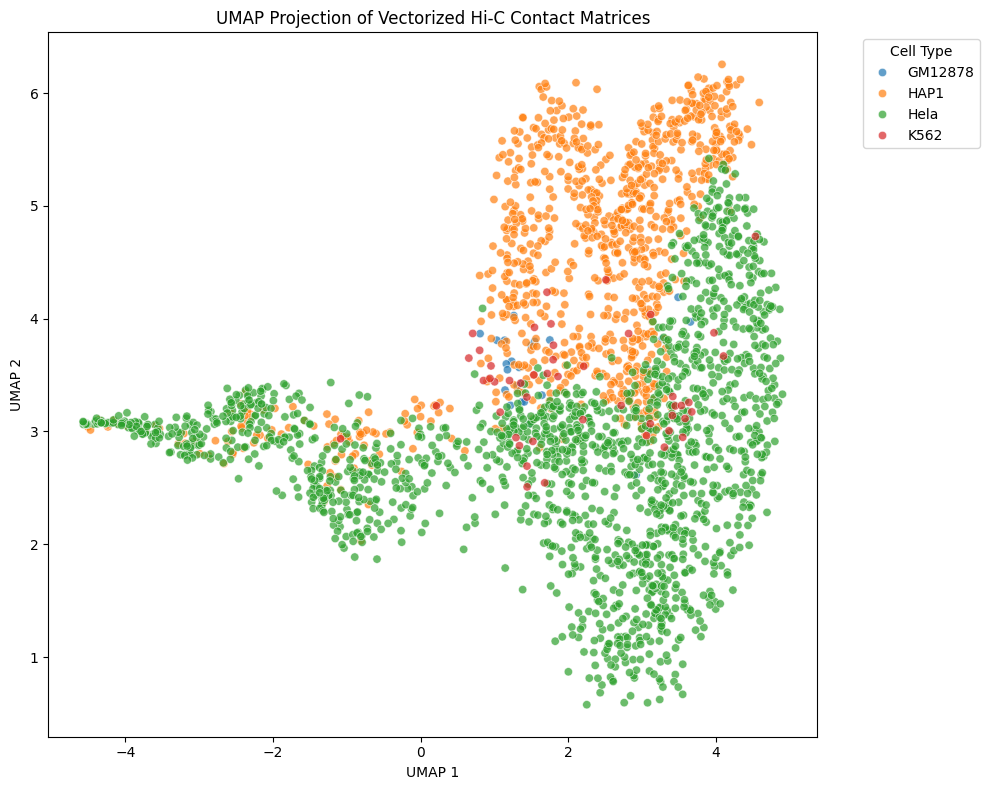

In [ ]:
# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)

# Apply UMAP
X_umap = reducer.fit_transform(X)

# Extract cell types from labels for coloring
cell_types = [label[0] for label in cell_labels]

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cell_types, palette='tab10', alpha=0.7)
plt.title("UMAP Projection of Vectorized Hi-C Contact Matrices")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 2D UMAP on X_sparse


In [8]:
X_sparse = sparse.csr_matrix(X)

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


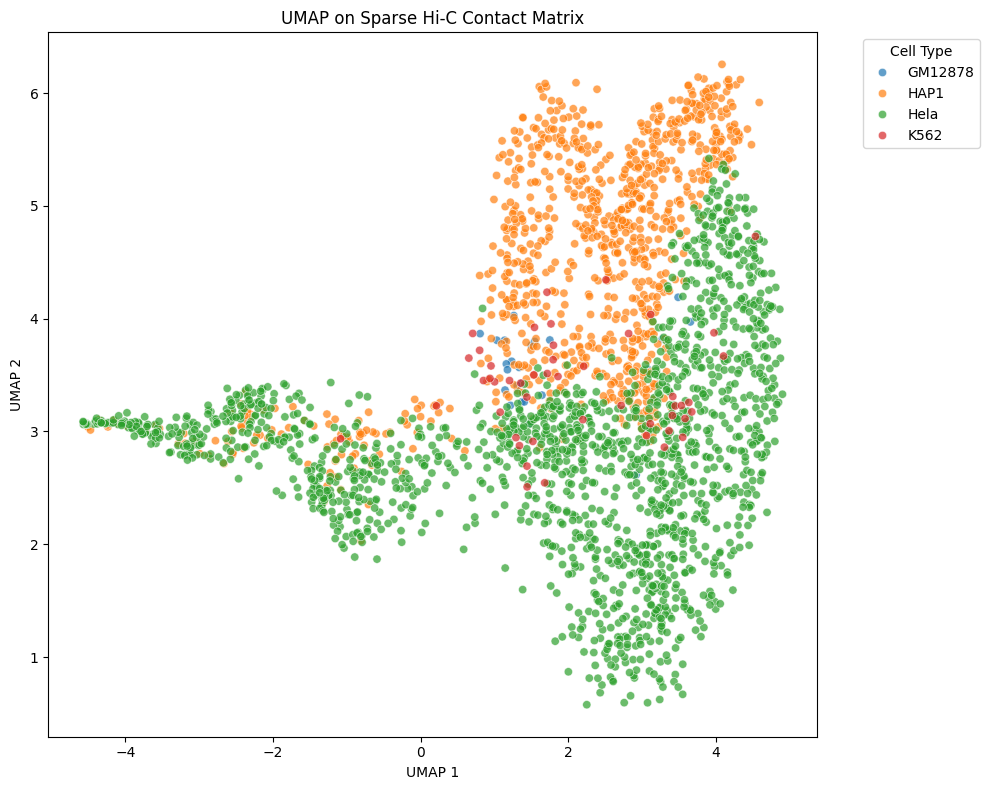

In [49]:
# Initialize UMAP
reducer = umap.UMAP(
    n_neighbors=15,       # or 30, tune if needed
    min_dist=0.1,         # lower = tighter clusters
    n_components=2,       # or 3 if 3D
    metric='euclidean',   
    random_state=42
)

# Fit-transform on sparse matrix
X_umap = reducer.fit_transform(X_sparse)

# Plotting by cell type
cell_types = [label[0] for label in cell_labels]
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cell_types, palette='tab10', alpha=0.7)
plt.title("UMAP on Sparse Hi-C Contact Matrix")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3D UMAP on X_sparse

C:\Users\annar\AppData\Local\Temp\ipykernel_13816\103649658.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=color_map[ct], label=ct)


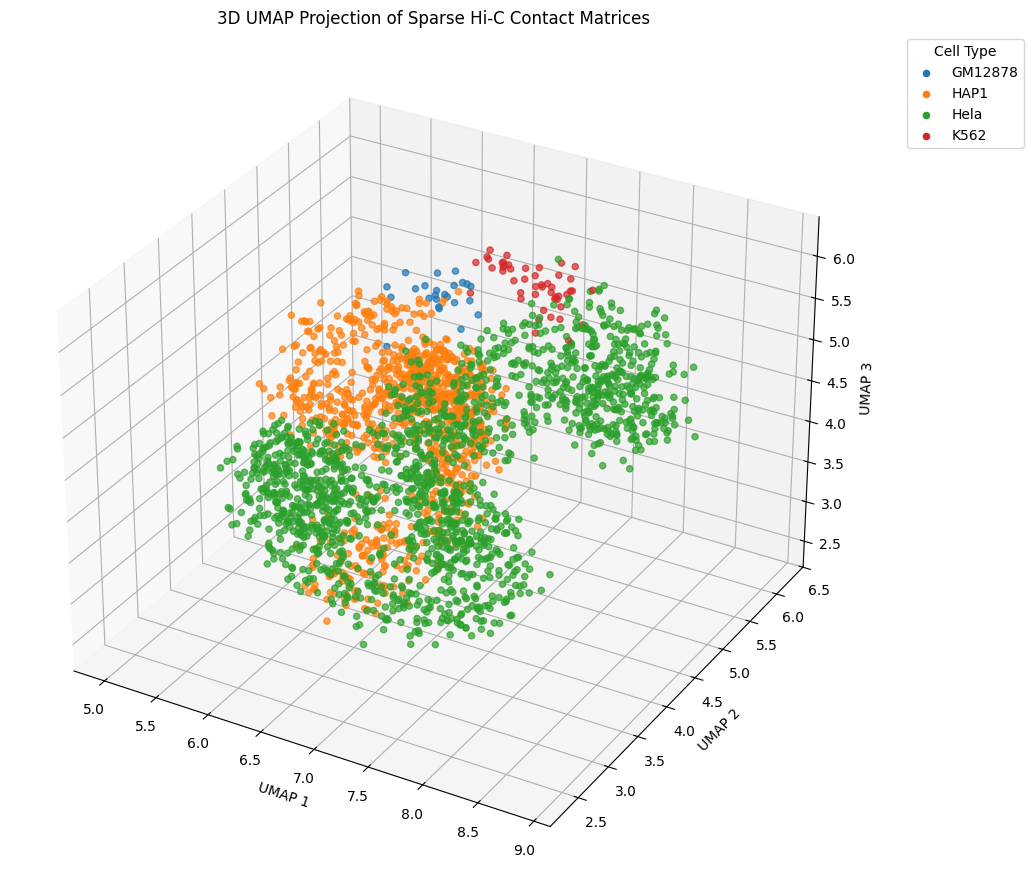

In [16]:
reducer_3d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=3,
    metric='cosine',  # or 'cosine'
    random_state=42
)

# Apply UMAP to sparse matrix
X_umap_3d = reducer_3d.fit_transform(X_sparse)

# Get cell types for coloring
cell_types = [label[0] for label in cell_labels]
unique_cell_types = sorted(set(cell_types))
palette = sns.color_palette("tab10", len(unique_cell_types))
color_map = dict(zip(unique_cell_types, palette))
colors = [color_map[ct] for ct in cell_types]

# 3D Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
                c=colors, alpha=0.7, s=20)

# Create legend manually
for ct in unique_cell_types:
    ax.scatter([], [], [], c=color_map[ct], label=ct)
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("3D UMAP Projection of Sparse Hi-C Contact Matrices")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.tight_layout()
plt.show()

## 2D UMAP after PCA

In [37]:
svd = TruncatedSVD(n_components=300, random_state=42)  # adjust if needed
X_svd = svd.fit_transform(X_sparse)
print("SVD-reduced shape:", X_svd.shape)

SVD-reduced shape: (2611, 300)


c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


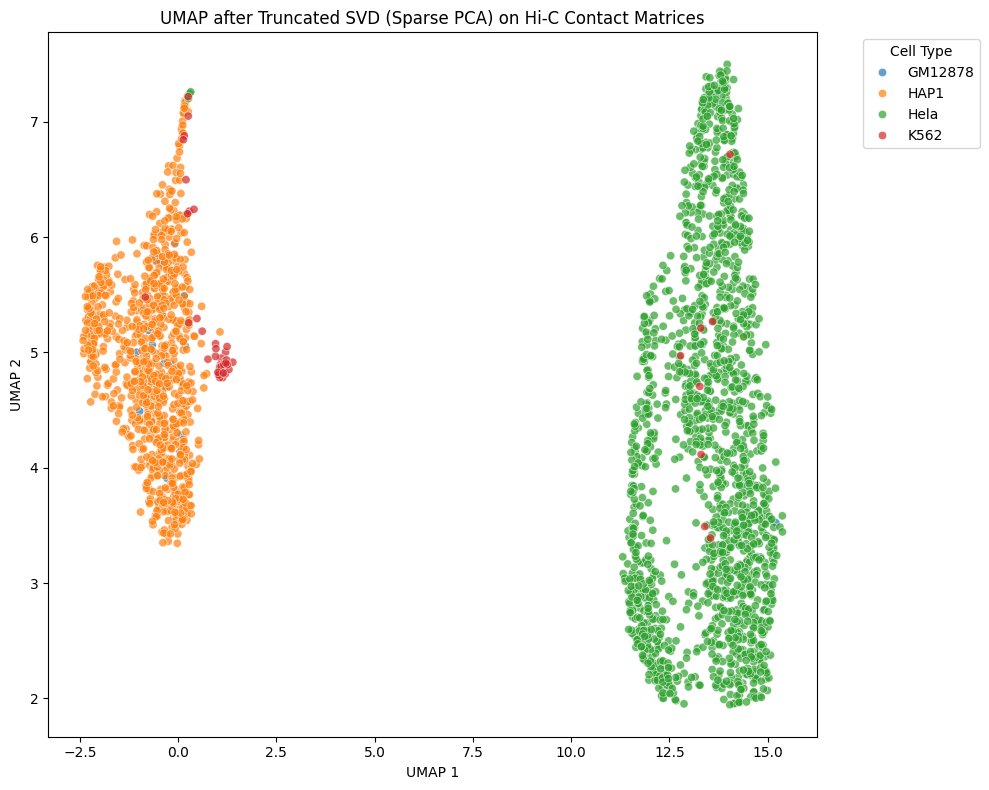

In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
X_umap_svd = reducer.fit_transform(X_svd)

# Step 3: Plotting
cell_types = [label[0] for label in cell_labels]
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap_svd[:, 0], y=X_umap_svd[:, 1], hue=cell_types, palette='tab10', alpha=0.7)
plt.title("UMAP after Truncated SVD (Sparse PCA) on Hi-C Contact Matrices")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3D UMAP after PCA

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\annar\AppData\Local\Temp\ipykernel_13816\2806813404.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=color_map[ct], label=ct)


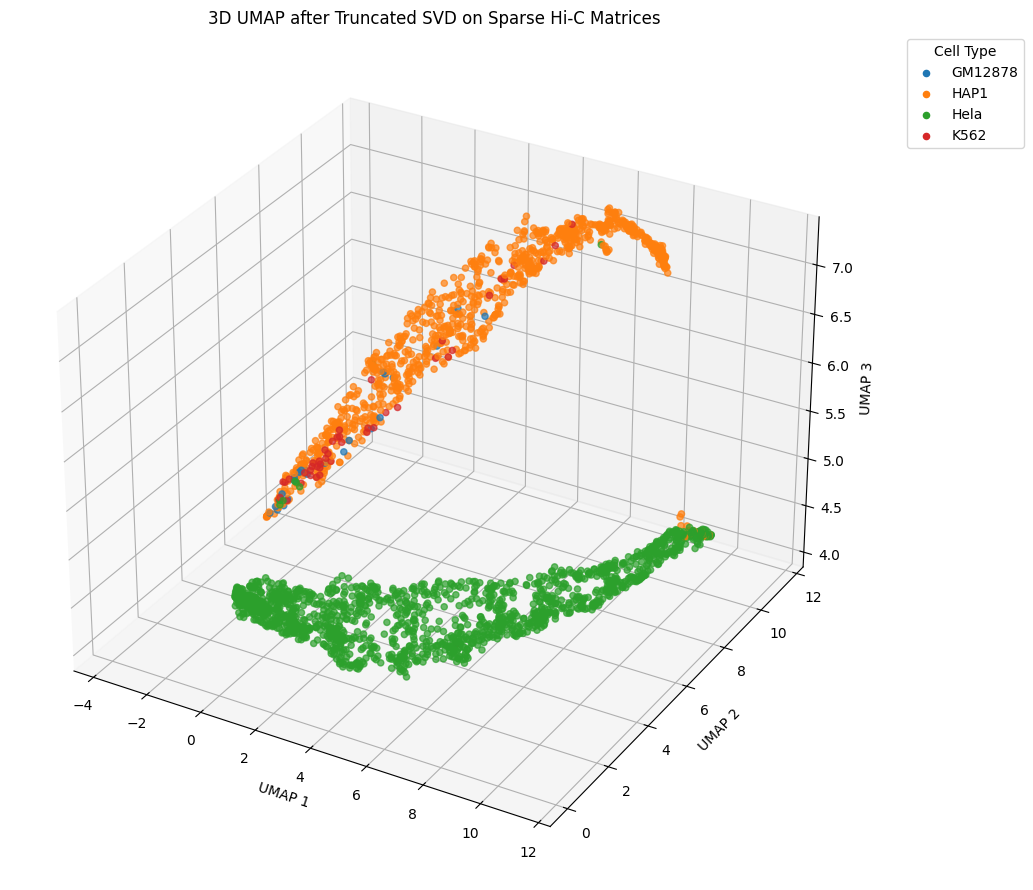

In [19]:
reducer_3d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric='euclidean',
    random_state=42
)
X_umap_3d = reducer_3d.fit_transform(X_svd)

# Step 3: Prepare for plotting
cell_types = [label[0] for label in cell_labels]
unique_cell_types = sorted(set(cell_types))
palette = sns.color_palette("tab10", len(unique_cell_types))
color_map = dict(zip(unique_cell_types, palette))
colors = [color_map[ct] for ct in cell_types]

# Step 4: 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
           c=colors, alpha=0.7, s=20)

# Manual legend
for ct in unique_cell_types:
    ax.scatter([], [], [], c=color_map[ct], label=ct)
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("3D UMAP after Truncated SVD on Sparse Hi-C Matrices")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.tight_layout()
plt.show()

## UMAP with normalization

In [24]:
from sklearn.preprocessing import normalize
X_svd_normalized = normalize(X_svd, norm='l2')

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


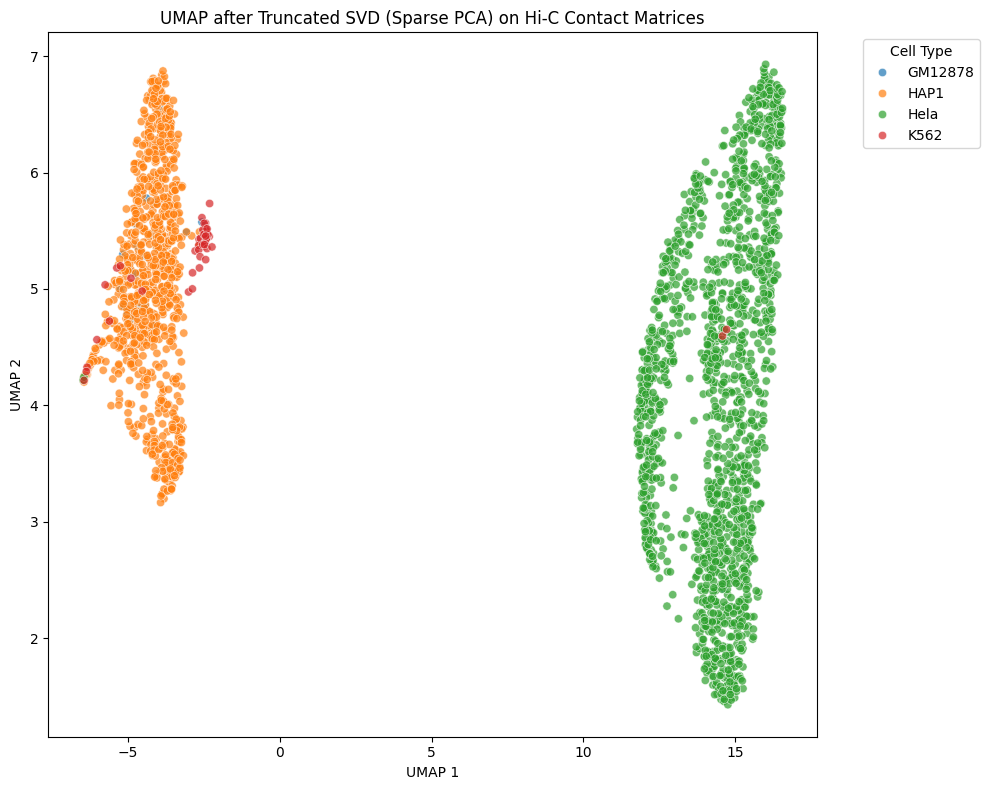

In [27]:
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)
X_umap_svd = reducer.fit_transform(X_svd_normalized)

# Step 3: Plotting
cell_types = [label[0] for label in cell_labels]
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap_svd[:, 0], y=X_umap_svd[:, 1], hue=cell_types, palette='tab10', alpha=0.7)
plt.title("UMAP after Truncated SVD (Sparse PCA) on Hi-C Contact Matrices")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\annar\AppData\Local\Temp\ipykernel_13816\486663331.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], [], c=color_map[ct], label=ct)


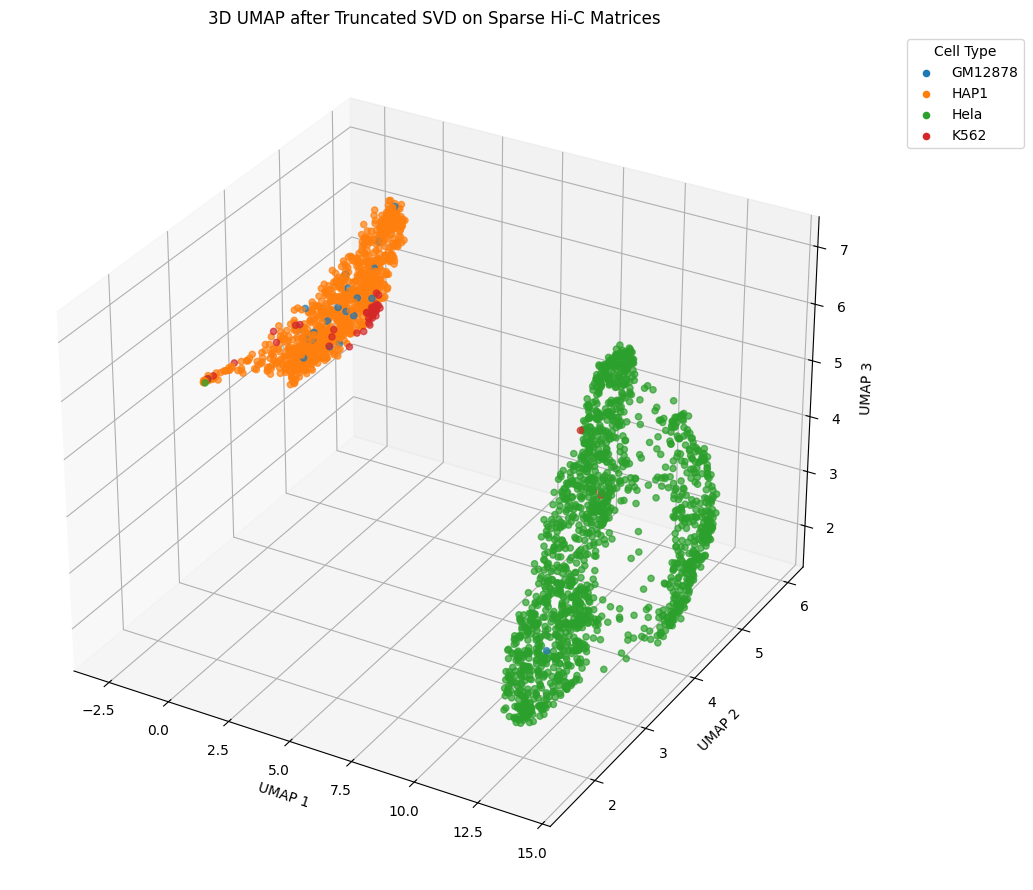

In [28]:
reducer_3d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    metric='cosine',
    random_state=42
)
X_umap_3d = reducer_3d.fit_transform(X_svd_normalized)

# Step 3: Prepare for plotting
cell_types = [label[0] for label in cell_labels]
unique_cell_types = sorted(set(cell_types))
palette = sns.color_palette("tab10", len(unique_cell_types))
color_map = dict(zip(unique_cell_types, palette))
colors = [color_map[ct] for ct in cell_types]

# Step 4: 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_umap_3d[:, 0], X_umap_3d[:, 1], X_umap_3d[:, 2],
           c=colors, alpha=0.7, s=20)

# Manual legend
for ct in unique_cell_types:
    ax.scatter([], [], [], c=color_map[ct], label=ct)
ax.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_title("3D UMAP after Truncated SVD on Sparse Hi-C Matrices")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
plt.tight_layout()
plt.show()

## Grid search for UMAP parameters

In [33]:
n_neighbors_list = [5, 15, 30]
min_dist_list = [0.0, 0.1, 0.3]
metrics = ['cosine', 'euclidean']

# Get cell type labels
cell_types = [label[0] for label in cell_labels]
palette = sns.color_palette("tab10", len(set(cell_types)))

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

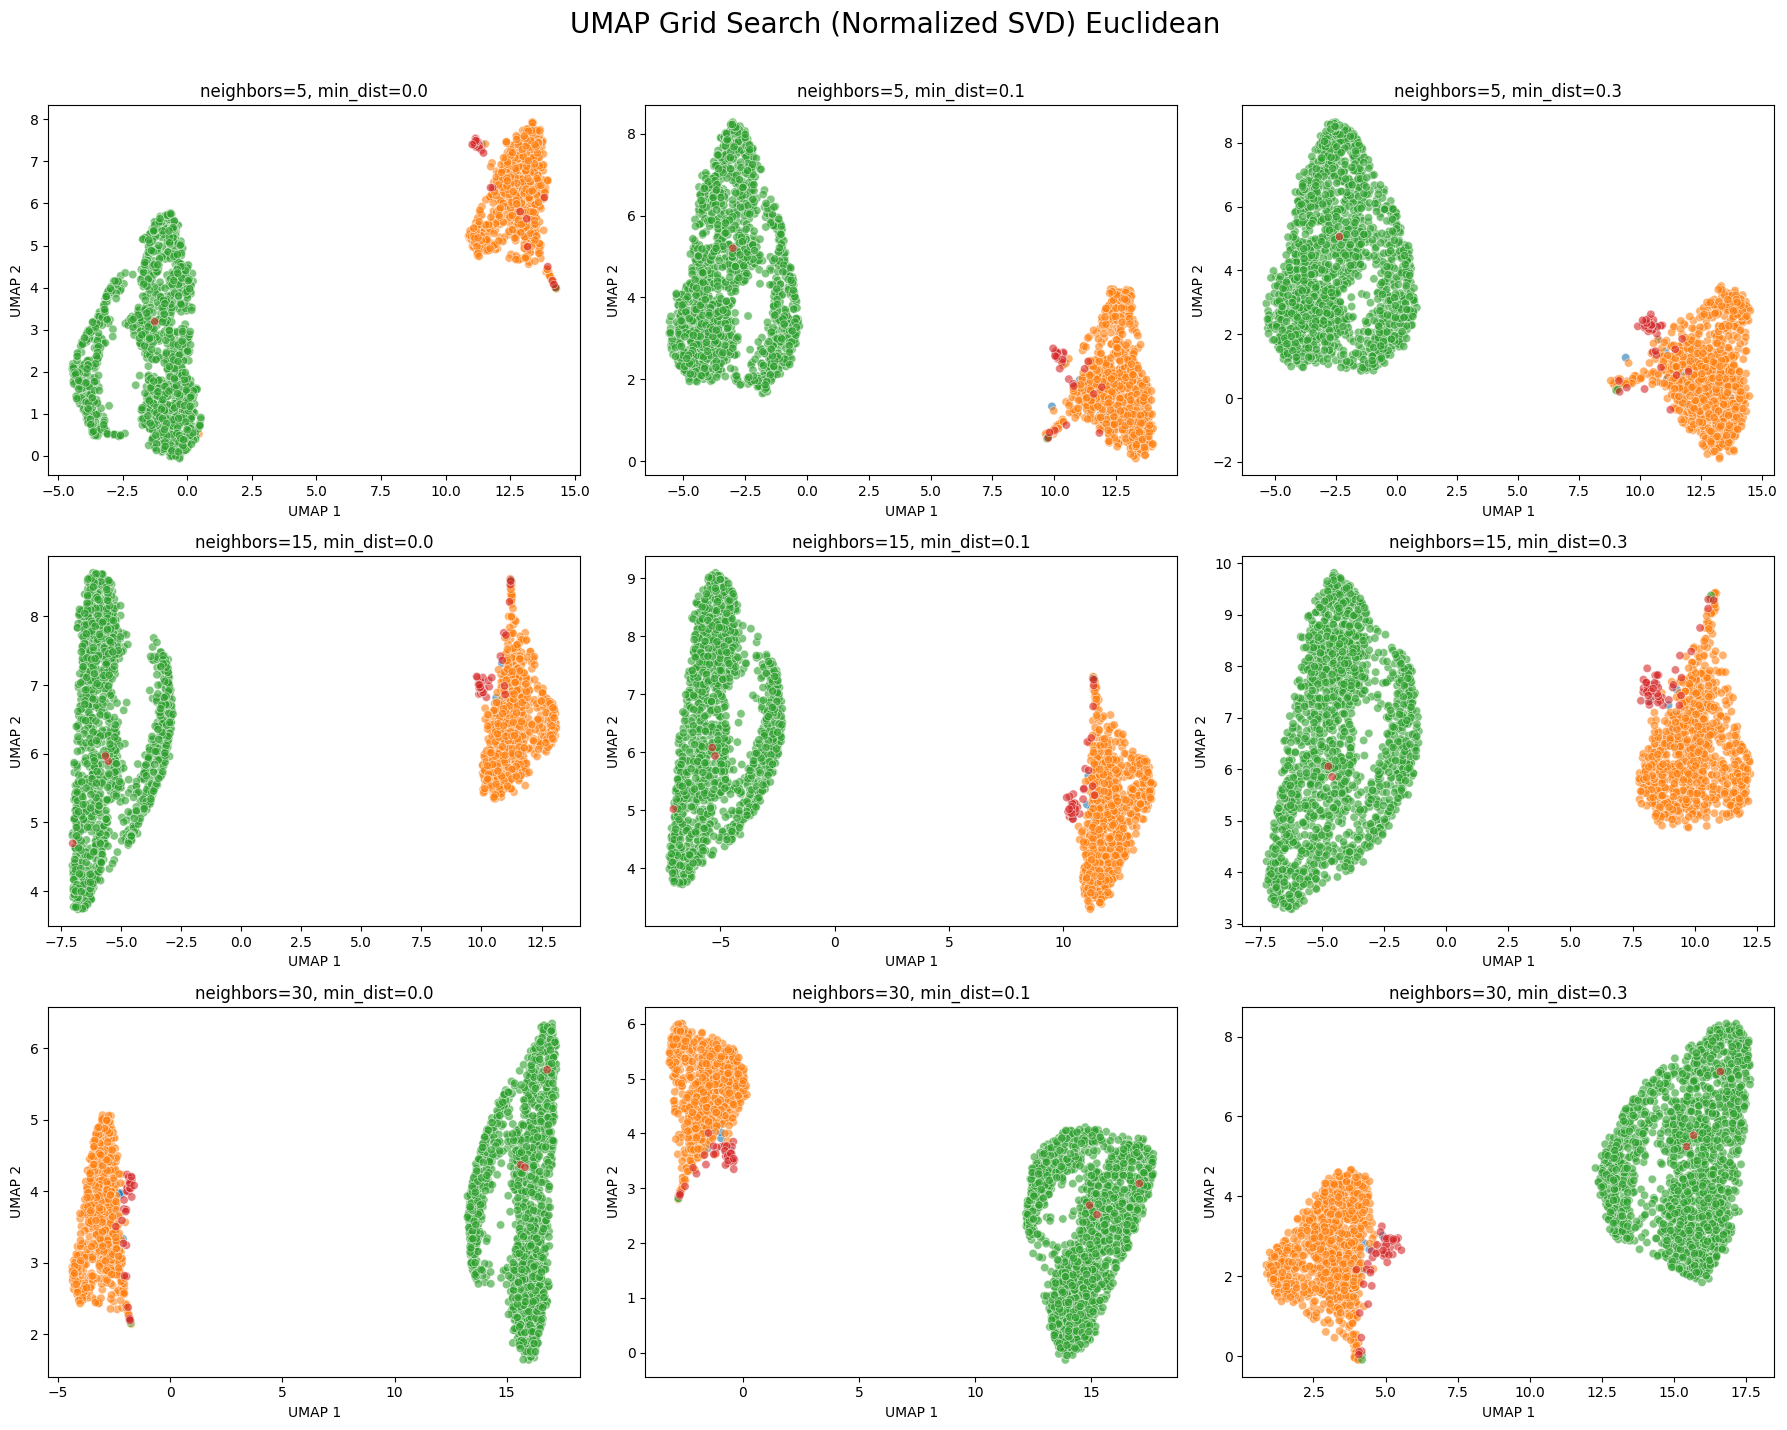

In [46]:
fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(18, 15))
fig.suptitle("UMAP Grid Search (Normalized SVD) Euclidean", fontsize=20)


for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        ax = axes[i, j]

        # Initialize UMAP
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric="euclidean",   # ← try 'euclidean' too if looping over `metrics`
            random_state=42
        )
            
        # Fit-transform
        X_umap = reducer.fit_transform(X_svd_normalized)
            
        # Scatterplot
        sns.scatterplot(
            x=X_umap[:, 0], y=X_umap[:, 1], hue=cell_types,
            palette=palette, alpha=0.6, ax=ax, legend=False
        )
        ax.set_title(f"neighbors={n_neighbors}, min_dist={min_dist}")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and

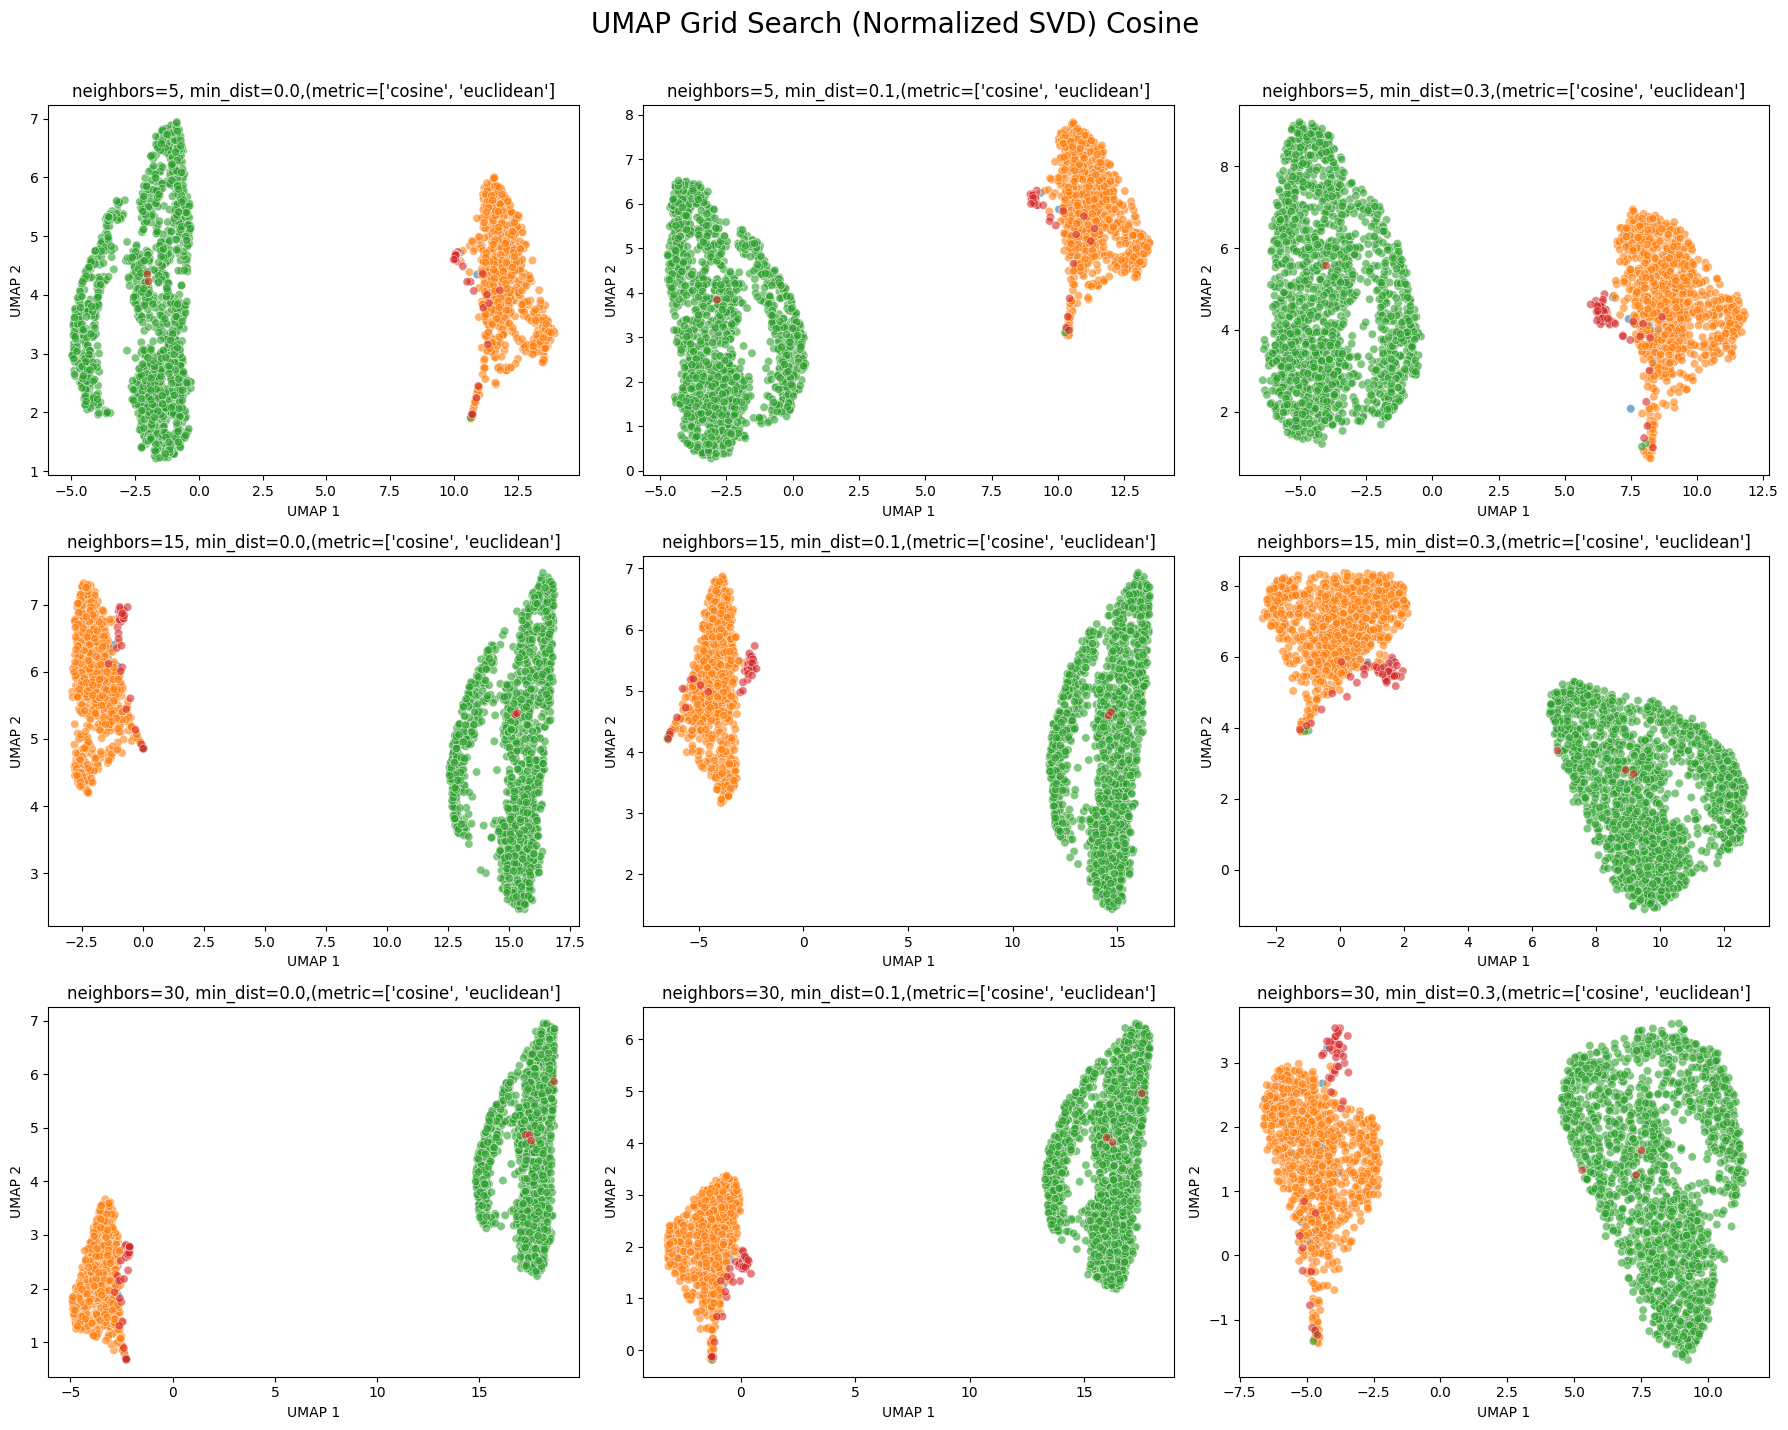

In [45]:
fig, axes = plt.subplots(len(n_neighbors_list), len(min_dist_list), figsize=(18, 15))
fig.suptitle("UMAP Grid Search (Normalized SVD) Cosine", fontsize=20)


for i, n_neighbors in enumerate(n_neighbors_list):
    for j, min_dist in enumerate(min_dist_list):
        ax = axes[i, j]

        # Initialize UMAP
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            metric="cosine",   # ← try 'euclidean' too if looping over `metrics`
            random_state=42
        )
            
        # Fit-transform
        X_umap = reducer.fit_transform(X_svd_normalized)
            
        # Scatterplot
        sns.scatterplot(
            x=X_umap[:, 0], y=X_umap[:, 1], hue=cell_types,
            palette=palette, alpha=0.6, ax=ax, legend=False
        )
        ax.set_title(f"neighbors={n_neighbors}, min_dist={min_dist},(metric={metrics}")
        ax.set_xlabel("UMAP 1")
        ax.set_ylabel("UMAP 2")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# Supervised UMAP

c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\annar\OneDrive\Documents\UTSSRP\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


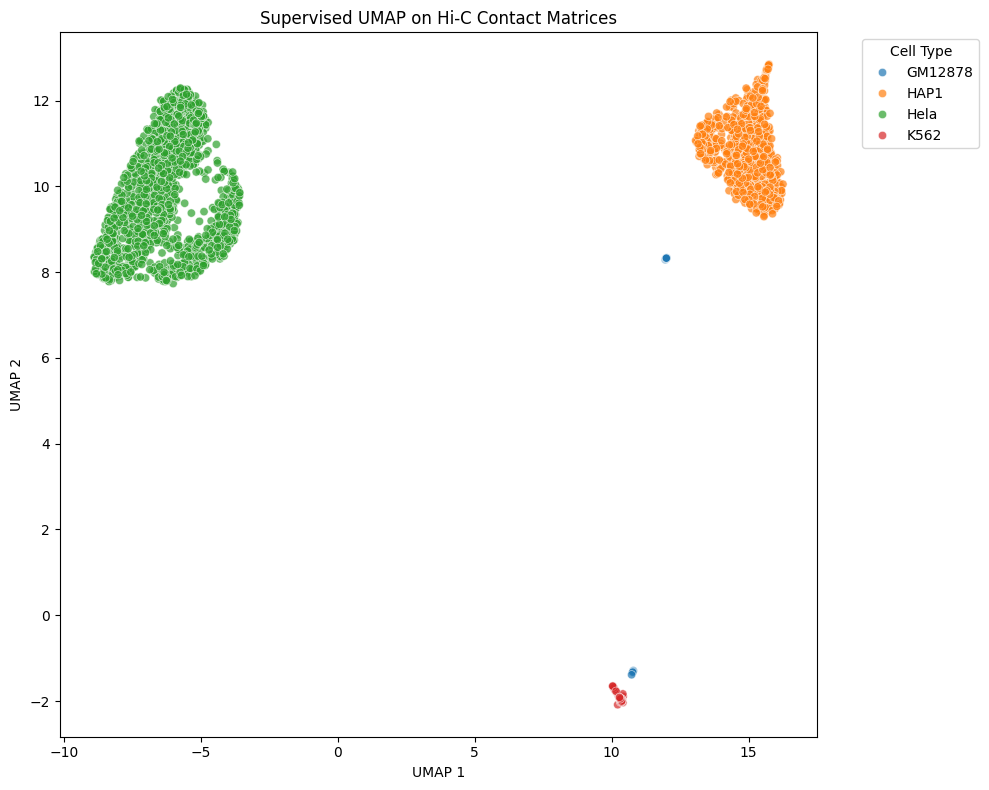

In [48]:
from sklearn.preprocessing import LabelEncoder

# Encode cell types into integers
le = LabelEncoder()
label_array = le.fit_transform(cell_types)  # now an array of ints

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)
X_umap_supervised = reducer.fit_transform(X_svd_normalized, y=label_array)

# Step 5: Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap_supervised[:, 0], y=X_umap_supervised[:, 1],
                hue=cell_types, palette='tab10', alpha=0.7)
plt.title("Supervised UMAP on Hi-C Contact Matrices")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
